Nesse script python iremos trabalhar com uma extensão da PNAD continua utilizando dados da PME. Construiremos duas séries, uma normal e outra dessazonalizada

# Instalando e Carregando bibliotecas

In [1]:
#Instalando biblioteca do Banco Central
!pip install python-bcb # api do banco central
#Carregando pacotes
import pandas as pd
from bcb import sgs
from plotnine import *
import statsmodels.api as sm
from statsmodels.tsa import x13
import os

# Coleta e tratamendo de dados

In [2]:
#Importando dados da PNAD e da PME
pme = pd.read_csv('https://aluno.analisemacro.com.br/download/56293/?tmstv=1700150552',sep= ';', decimal= ',')

In [3]:
pme

,Unnamed: 0,pme
0,mar/02,12.922100
1,abr/02,12.511135
2,mai/02,11.879565
3,jun/02,11.574304
4,jul/02,11.863824
...,...,...
163,out/15,7.819489
164,nov/15,7.491011
165,dez/15,6.947006
166,jan/16,7.557719


In [4]:
# Ponto de inicio
start_date = pd.to_datetime('2002-03')

# Ponto de fim
end_date = pd.to_datetime('2016-02')

#Intervalo de datas mensais
pme['Date'] = pd.date_range(start=start_date, end=end_date, freq='MS')

#Renomeando coluna
pme.drop('Unnamed: 0', axis= 1, inplace=True)

#Define a data como indice
pme.set_index('Date', inplace=True)

In [5]:
pme

,pme
Date,
2002-03-01,12.922100
2002-04-01,12.511135
2002-05-01,11.879565
2002-06-01,11.574304
2002-07-01,11.863824
...,...
2015-10-01,7.819489
2015-11-01,7.491011
2015-12-01,6.947006


In [6]:
# Importando série da PNAD do Banco Central
pnad = sgs.get({'pnad': 24369})

In [7]:
pnad

,pnad
Date,
2012-03-01,8.0
2012-04-01,7.8
2012-05-01,7.7
2012-06-01,7.6
2012-07-01,7.5
...,...
2025-05-01,6.2
2025-06-01,5.8
2025-07-01,5.6


# Junção das duas bases

In [8]:
# Aqui iremos juntar os dois data frames pelo indice usando o método outer. Depois de feita a junção é necessario igualar a base de dados pois a pme vai de 03/2002 até 02/2016, enquanto
# a pnad vai de 03/2012 até os dias atuais.
dados = pnad.join(pme, how = 'outer')
dados

,pnad,pme
Date,,
2002-03-01,NaN,12.922100
2002-04-01,NaN,12.511135
2002-05-01,NaN,11.879565
2002-06-01,NaN,11.574304
2002-07-01,NaN,11.863824
...,...,...
2025-05-01,6.2,NaN
2025-06-01,5.8,NaN
2025-07-01,5.6,NaN


In [9]:
#Juntando pelo método inner
dados_atuais = pnad.join(pme, how = 'inner').reset_index()
dados_atuais.tail()

,Date,pnad,pme
43,2015-10-01,9.1,7.819489
44,2015-11-01,9.1,7.491011
45,2015-12-01,9.1,6.947006
46,2016-01-01,9.6,7.557719
47,2016-02-01,10.3,8.201058


In [10]:
#Tranformar wide to long
dados_atuais_long = dados_atuais.melt(id_vars=['Date'])

In [11]:
#Cores para o gráfico
colors = {'blue': '#282f6b',
          'yellow': '#eace3f',
          'red': '#b22200',
          'green': '#224f20',
          'purple': '#5f487c',
          'gray': '#666666',
          'orange': '#b35c1e'}

/usr/local/lib/python3.12/dist-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


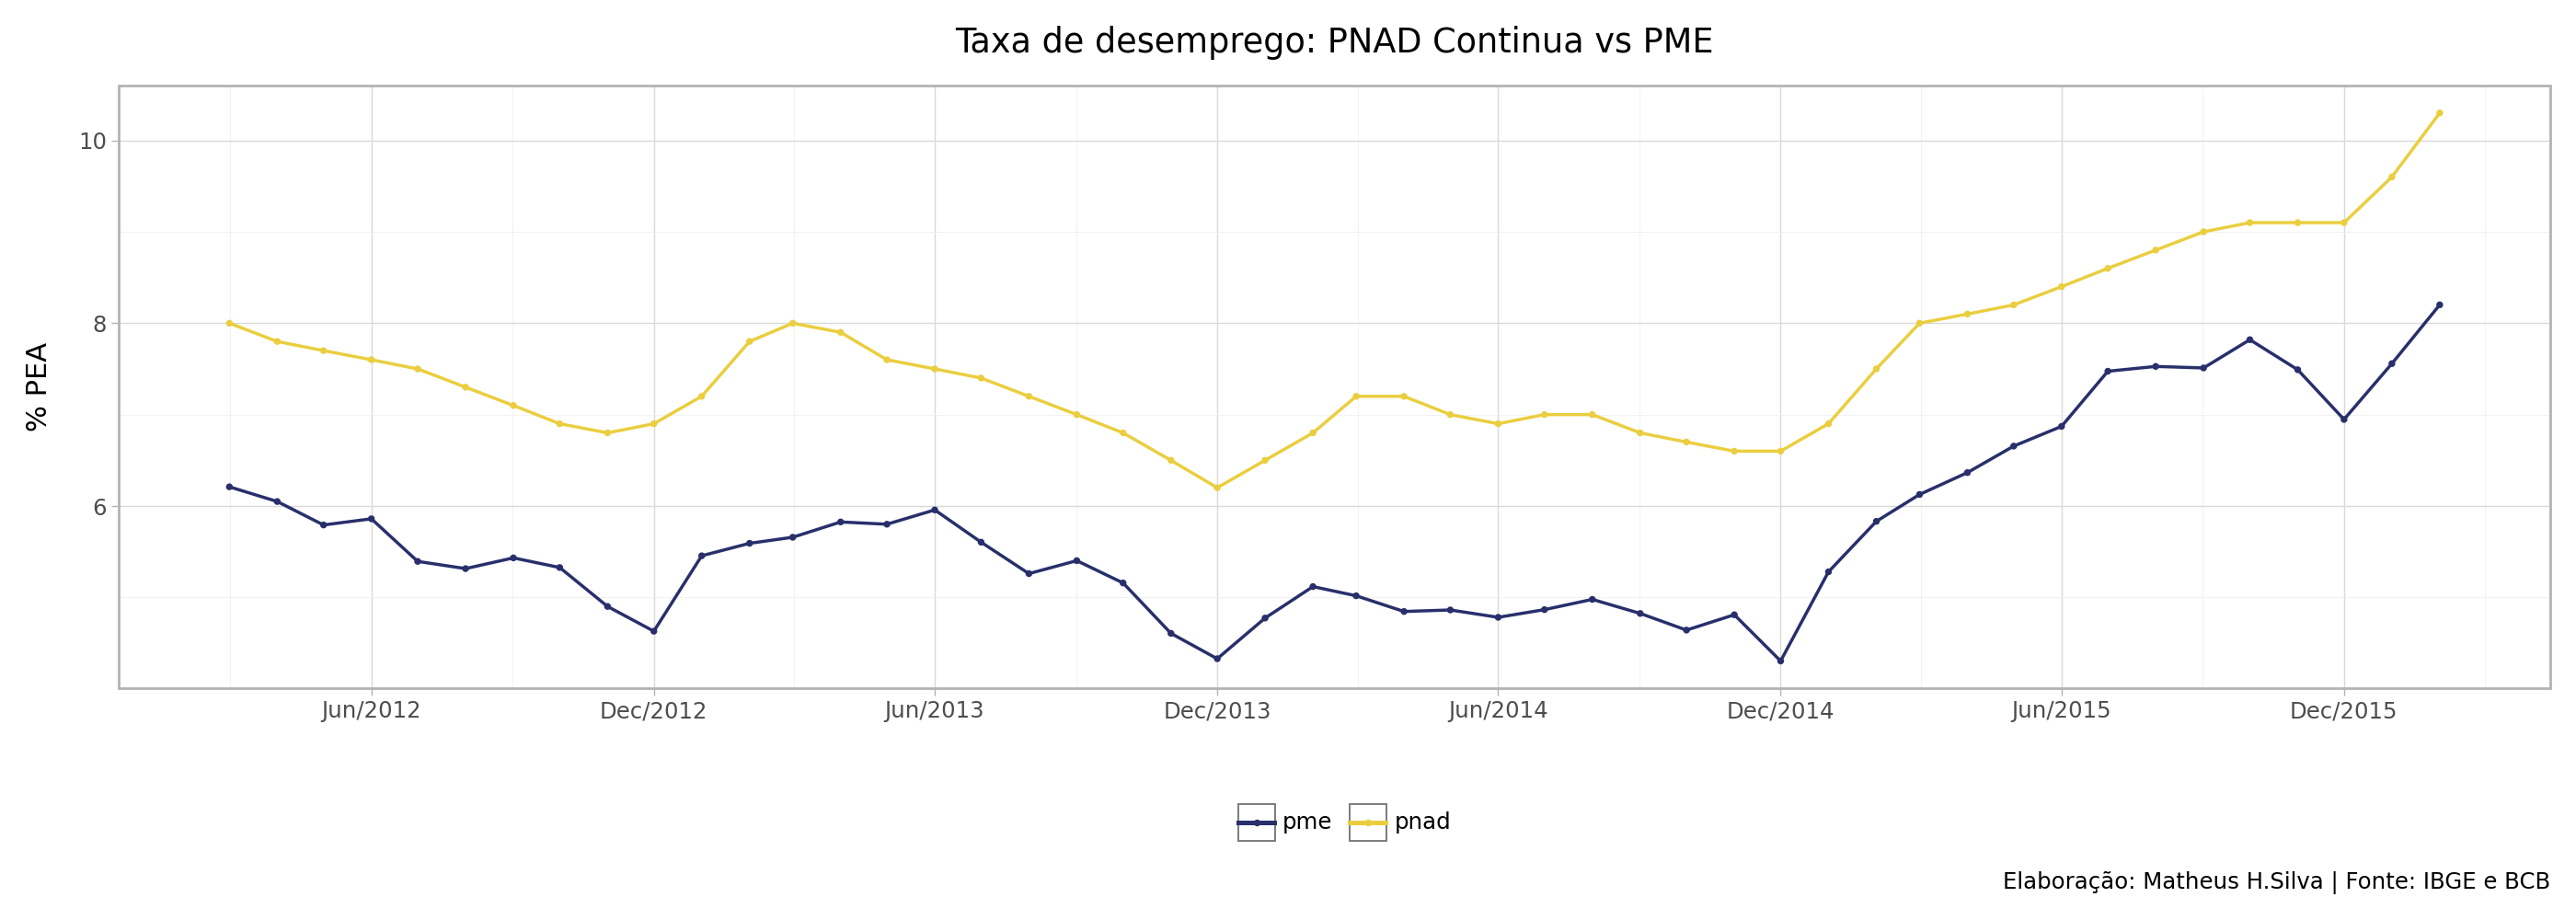

In [12]:
#gráfico
(ggplot(dados_atuais_long, aes(x= 'Date', y= 'value', color= 'variable'))+
 geom_line(size = 0.7)+
 geom_point(size = 0.5)+
 scale_colour_manual(values=list(colors.values()))+
 scale_x_date(date_breaks='6 month', date_labels='%b/%Y')+
 labs(title= f'Taxa de desemprego: PNAD Continua vs PME',
      color='',
      x='',
      y='% PEA',
      caption='Elaboração: Matheus H.Silva | Fonte: IBGE e BCB')+
 theme_light() + theme(figure_size= (14,5), legend_position='bottom')
 )

In [13]:
dados_atuais.describe()

,Date,pnad,pme
count,48,48.000000,48.000000
mean,2014-02-14 20:00:00,7.577083,5.730090
min,2012-03-01 00:00:00,6.200000,4.304397
25%,2013-02-22 00:00:00,6.900000,4.892217
50%,2014-02-15 00:00:00,7.350000,5.443909
75%,2015-02-08 00:00:00,8.000000,6.147074
max,2016-02-01 00:00:00,10.300000,8.201058
std,NaN,0.905360,1.010961


# Ampliando a série da PNAD

In [14]:
# Regressão linear
formula = 'pnad ~ pme'
reg_model = sm.OLS.from_formula(formula, data=dados_atuais).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   pnad   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     562.5
Date:                Fri, 31 Oct 2025   Prob (F-statistic):           1.95e-27
Time:                        20:32:09   Log-Likelihood:               -0.85687
No. Observations:                  48   AIC:                             5.714
Df Residuals:                      46   BIC:                             9.456
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6433      0.211     12.517      0.0

In [15]:
#Criando data frame com dados do modelo e dos dados originais (Opcional)
#reg = pd.DataFrame({'Desemprego PNAD Continua': dados_atuais['pnad'], 'Modelo': reg.fittedvalues, 'Date': dados_atuais['Date']})
#model.head()

NameError: name 'reg' is not defined

In [ ]:
# Transformação wide to long do modelo (Opcional)
#model_long = reg.melt(id_vars=['Date'])

In [ ]:
#gráfico (Opcional)
#(
 #ggplot(model_long, aes(x= 'Date', y= 'value', color= 'variable'))+
 #geom_line(size = 0.7)+
# geom_point(size = 0.5)+
 #scale_colour_manual(values=list(colors.values()))+
 #scale_x_date(date_breaks='6 month', date_labels='%b/%Y')+
 #labs(title= f'Taxa de desemprego: PNAD Continua vs Modelo',
 #     color='',
 #     x='',
 #     y='% PEA',
 #     caption='Elaboração: Matheus H.Silva | Fonte: IBGE e BCB')+
 #theme_light() + theme(figure_size= (14,5), legend_position='bottom')
 #)

In [16]:
# Criando série PNAD Continua ampliada
pnad_pme = dados[~dados['pnad'].notna()].copy()
# Use the original model object from the OLS regression
pnad_pme['pnad']= reg_model.params.Intercept + reg_model.params.pme * pnad_pme['pme']
#Concatenando os dados
pnad_ampliada = pd.concat([pnad_pme[['pnad']], dados[['pnad']].dropna()])
pnad_ampliada

,pnad
Date,
2002-03-01,13.769594
2002-04-01,13.415742
2002-05-01,12.871943
2002-06-01,12.609105
2002-07-01,12.858390
...,...
2025-05-01,6.200000
2025-06-01,5.800000
2025-07-01,5.600000


/usr/local/lib/python3.12/dist-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


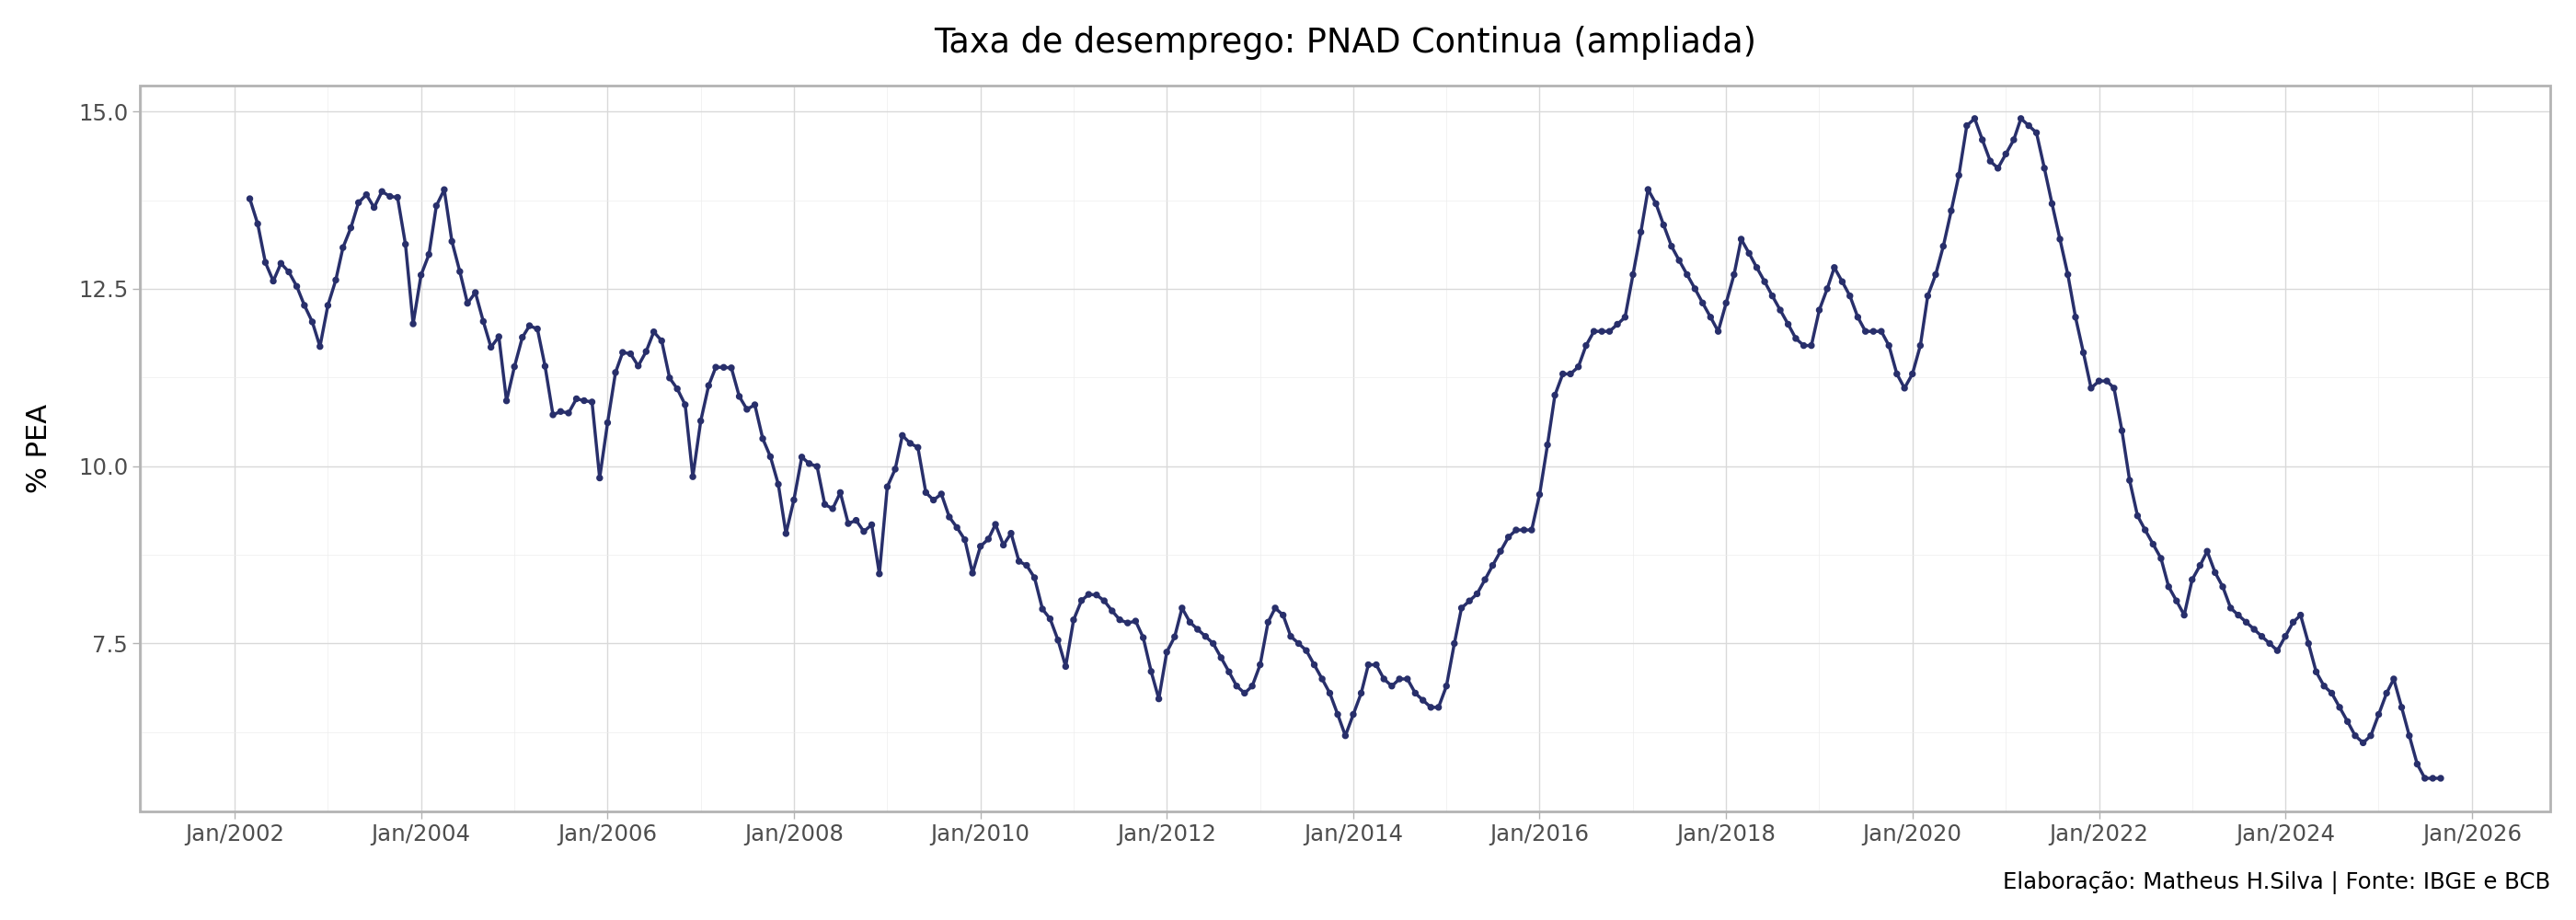

In [17]:
#Gráfico da base ampliada
(
 ggplot(pnad_ampliada.reset_index(), aes(x= 'Date', y= 'pnad', color= 'variable'))+
 geom_line(size = 0.7, color='#282f6b')+
 geom_point(size = 0.5, color='#282f6b')+
 scale_x_date(date_breaks='2 years', date_labels='%b/%Y')+
 labs(title= f'Taxa de desemprego: PNAD Continua (ampliada)',
      color='',
      x='',
      y='% PEA',
      caption='Elaboração: Matheus H.Silva | Fonte: IBGE e BCB')+
 theme_light() + theme(figure_size= (14,5), legend_position='bottom')
 )

# Dessazonalização

In [18]:
#Download do X13-ARIMA-SEATS
# Baixar o pacote
!wget https://www2.census.gov/software/x-13arima-seats/x13as/unix-linux/program-archives/x13as_ascii-v1-1-b62.tar.gz

# Extrair o arquivo
!tar -xvzf x13as_ascii-v1-1-b62.tar.gz

# Configurar o caminho do executável
os.environ["X13PATH"] = "/content/x13as/x13as_ascii"


--2025-10-31 20:33:46--  https://www2.census.gov/software/x-13arima-seats/x13as/unix-linux/program-archives/x13as_ascii-v1-1-b62.tar.gz
Resolving www2.census.gov (www2.census.gov)... 172.65.90.27, 172.65.90.26, 172.65.90.25, ...
Connecting to www2.census.gov (www2.census.gov)|172.65.90.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3837943 (3.7M) [application/x-tar]
Saving to: ‘x13as_ascii-v1-1-b62.tar.gz’

x13as_ascii-v1-1-b6 100%[===================>]   3.66M  10.1MB/s    in 0.4s    

2025-10-31 20:33:47 (10.1 MB/s) - ‘x13as_ascii-v1-1-b62.tar.gz’ saved [3837943/3837943]

x13as/
x13as/docs/
x13as/docs/docX13AS.pdf
x13as/docs/qrefX13ASunix.pdf
x13as/testairline.spc
x13as/x13as_ascii


In [19]:


# Ajuste sazonal
res = sm.tsa.x13_arima_analysis(
    endog=pnad_ampliada["pnad"],
    x12path=os.environ["X13PATH"]
)


In [20]:
# Adiciona a coluna dessazonalizada
pnad_ampliada = pnad_ampliada.assign(pnad_sa=res.seasadj).reset_index()

In [21]:
pnad_ampliada

,Date,pnad,pnad_sa
0,2002-03-01,13.769594,13.215922
1,2002-04-01,13.415742,12.773219
2,2002-05-01,12.871943,12.481489
3,2002-06-01,12.609105,12.451337
4,2002-07-01,12.858390,12.826420
...,...,...,...
278,2025-05-01,6.200000,6.083071
279,2025-06-01,5.800000,5.878561
280,2025-07-01,5.600000,5.692496
281,2025-08-01,5.600000,5.747897


In [22]:
#transformar wide to long
pnad_ampliada_long = pnad_ampliada.melt(id_vars=['Date'])

/usr/local/lib/python3.12/dist-packages/mizani/breaks.py:448: FutureWarning: Passing the width as the parameter has been deprecated and will not work in a future version. Use breaks_date(width="4 years")


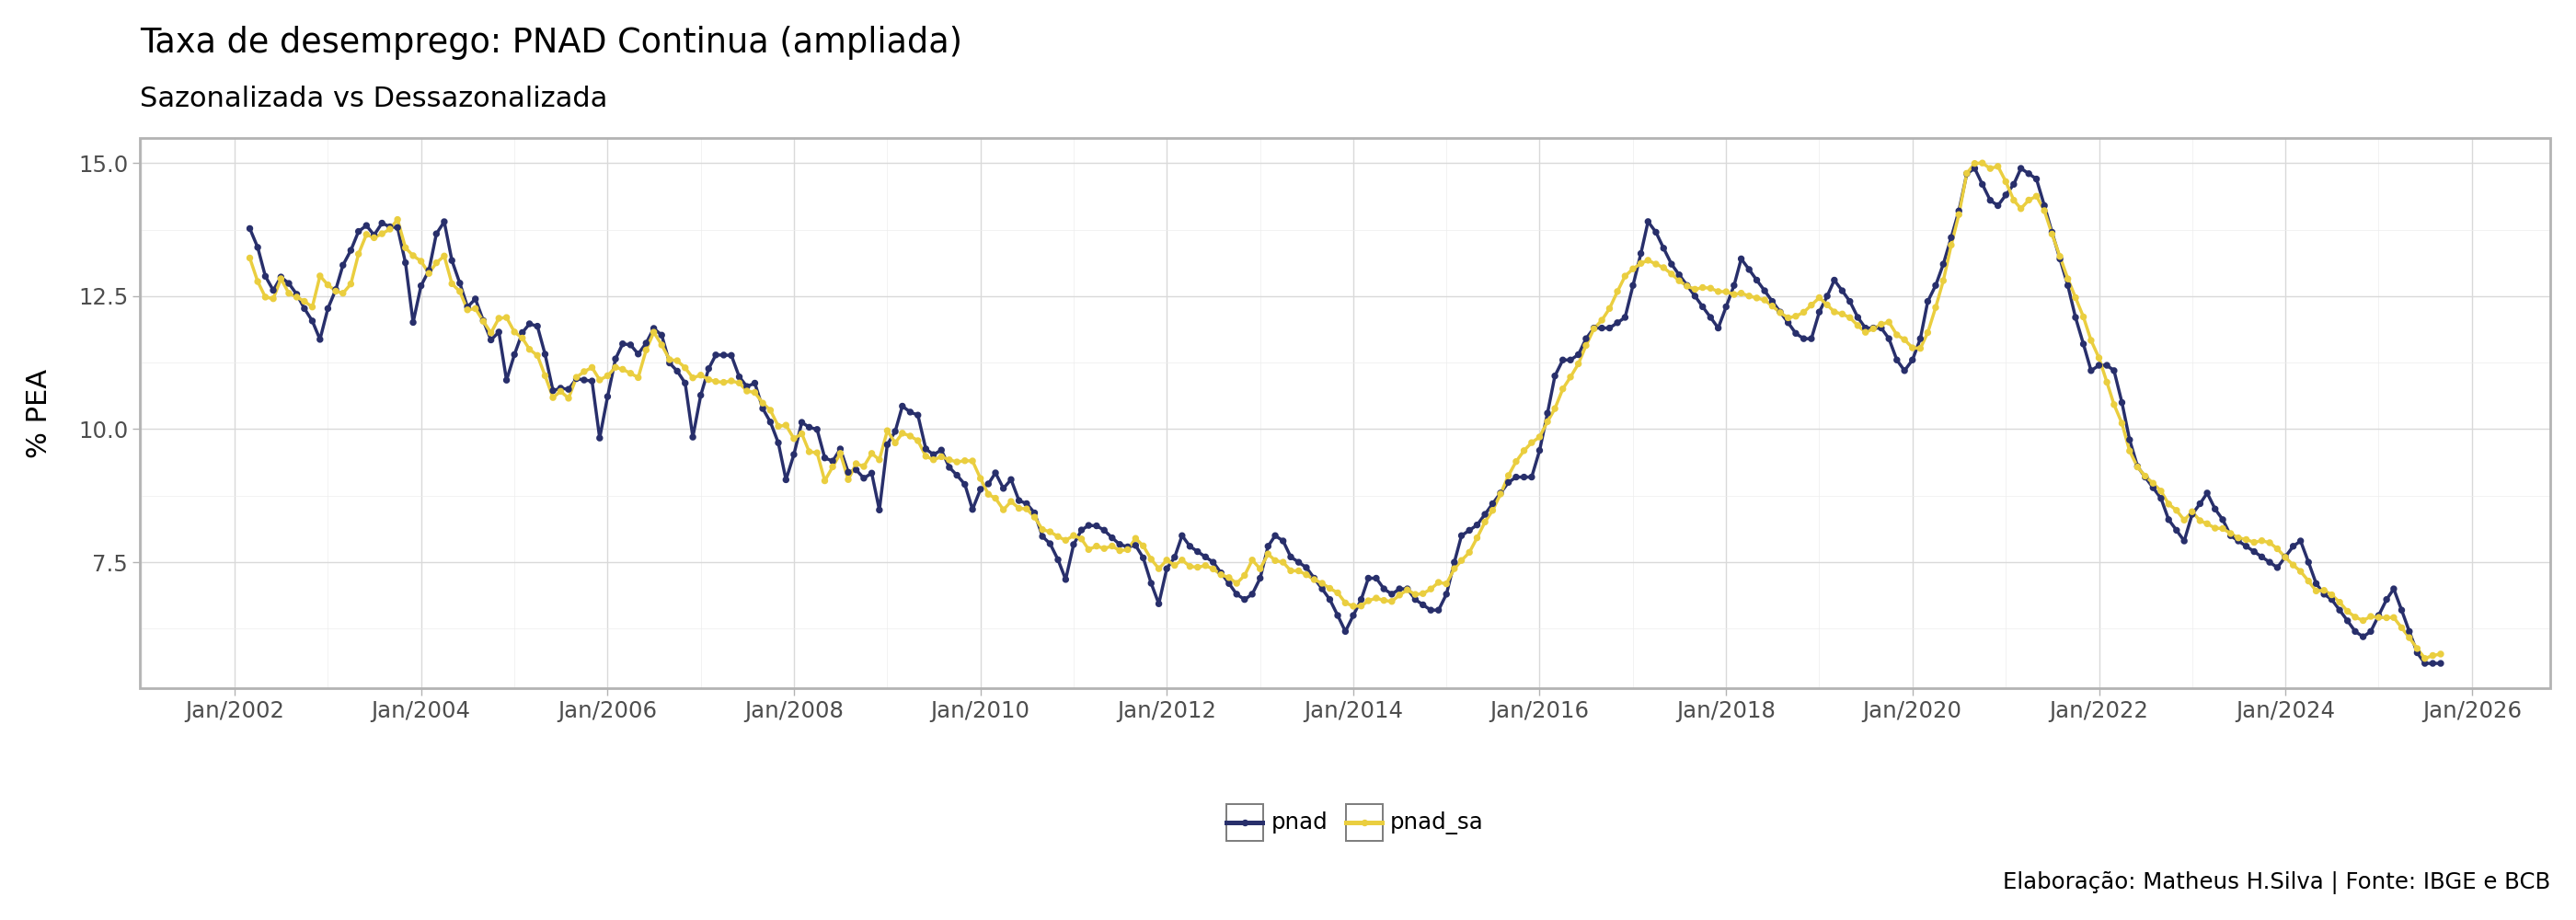

In [23]:
# gráfico
(
 ggplot(pnad_ampliada_long, aes(x= 'Date', y= 'value', color= 'variable'))+
 geom_line(size = 0.7)+
 geom_point(size = 0.5)+
 scale_colour_manual(values=list(colors.values()))+
 scale_x_date(date_breaks='2 years', date_labels='%b/%Y')+
 labs(title= f'Taxa de desemprego: PNAD Continua (ampliada)',
      subtitle = 'Sazonalizada vs Dessazonalizada',
      color='',
      x='',
      y='% PEA',
      caption='Elaboração: Matheus H.Silva | Fonte: IBGE e BCB')+
 theme_light() + theme(figure_size= (14,5), legend_position='bottom')
 )

In [27]:
from google.colab import files

# Exporta para Excel
pnad_ampliada.to_excel("pnad_ampliada.xlsx", index=False)

# Faz o download para sua máquina
files.download("pnad_ampliada.xlsx")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>